In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt      # Widen console display

In [2]:
comp_data = Path("/kaggle/input/MABe-mouse-behavior-detection")
comp_annotations = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation")
comp_tracking = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking")
for dir in comp_data.iterdir():
    print(dir)
    

/kaggle/input/MABe-mouse-behavior-detection/sample_submission.csv
/kaggle/input/MABe-mouse-behavior-detection/test_tracking
/kaggle/input/MABe-mouse-behavior-detection/train_annotation
/kaggle/input/MABe-mouse-behavior-detection/train.csv
/kaggle/input/MABe-mouse-behavior-detection/test.csv
/kaggle/input/MABe-mouse-behavior-detection/train_tracking


In [3]:
column_counts = Counter()
tracking_files = list(comp_tracking.rglob("*.parquet"))
N = 15
for f in tqdm(tracking_files[:N], desc="Counting columns"):
    try: # Tries to read in that file and updatet the column count appropriately
        df = pd.read_parquet(f, columns=None)
        column_counts.update(df.columns)
    except Exception as e:
        print(f"Error reading {f.name}: {e}")

# Convert to dictionary
column_counts_dict = dict(column_counts)

# Sort by frequency (most common first)
column_counts_sorted = dict(sorted(column_counts_dict.items(), key=lambda x: x[1], reverse=True))

print(f"Found {len(column_counts_sorted)} unique column names.")
for col, count in list(column_counts_sorted.items())[:20]:
    print(f"{col}: {count}")

Counting columns:   0%|          | 0/15 [00:00<?, ?it/s]

Found 5 unique column names.
video_frame: 15
mouse_id: 15
bodypart: 15
x: 15
y: 15


In [4]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter

comp_tracking = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking")
tracking_files = list(comp_tracking.rglob("*.parquet"))

unique_columns = set()
bodypart_counts = Counter()  # to count how many files each bodypart appears in
N = 20  # adjust as needed

# Loop through a subset (or all) of the files
for f in tqdm(tracking_files[::], desc="Analyzing files"):  # can limit to first N for testing
    try:
        df = pd.read_parquet(f)
        unique_columns.update(df.columns)
        
        # Only collect unique entries from 'bodypart' if that column exists
        if 'bodypart' in df.columns:
            bodyparts_in_file = df['bodypart'].dropna().unique()
            bodypart_counts.update(bodyparts_in_file)
            
    except Exception as e:
        print(f"Error reading {f.name}: {e}")

# Sort by most frequent bodyparts
bodypart_counts_sorted = dict(sorted(bodypart_counts.items(), key=lambda x: x[1], reverse=True))

# Print column names
print(f"Found {len(unique_columns)} unique column names:")
for col in sorted(unique_columns):
    print(f"- {col}")

# Print bodyparts and frequencies
print(f"\nFound {len(bodypart_counts_sorted)} unique bodyparts:")
for bp, count in bodypart_counts_sorted.items():
    print(f"{bp}: {count}")



Analyzing files:   0%|          | 0/8789 [00:00<?, ?it/s]

Found 5 unique column names:
- bodypart
- mouse_id
- video_frame
- x
- y

Found 29 unique bodyparts:
ear_left: 8789
ear_right: 8789
tail_base: 8789
nose: 8772
neck: 8577
body_center: 8114
tail_tip: 8030
tail_midpoint: 7943
forepaw_left: 7926
forepaw_right: 7926
hindpaw_left: 7926
hindpaw_right: 7926
hip_left: 655
hip_right: 655
lateral_left: 169
lateral_right: 169
spine_1: 21
spine_2: 21
tail_middle_1: 21
tail_middle_2: 21
head: 17
headpiece_bottombackleft: 7
headpiece_bottombackright: 7
headpiece_bottomfrontright: 7
headpiece_topbackleft: 7
headpiece_topbackright: 7
headpiece_topfrontleft: 7
headpiece_topfrontright: 7
headpiece_bottomfrontleft: 7


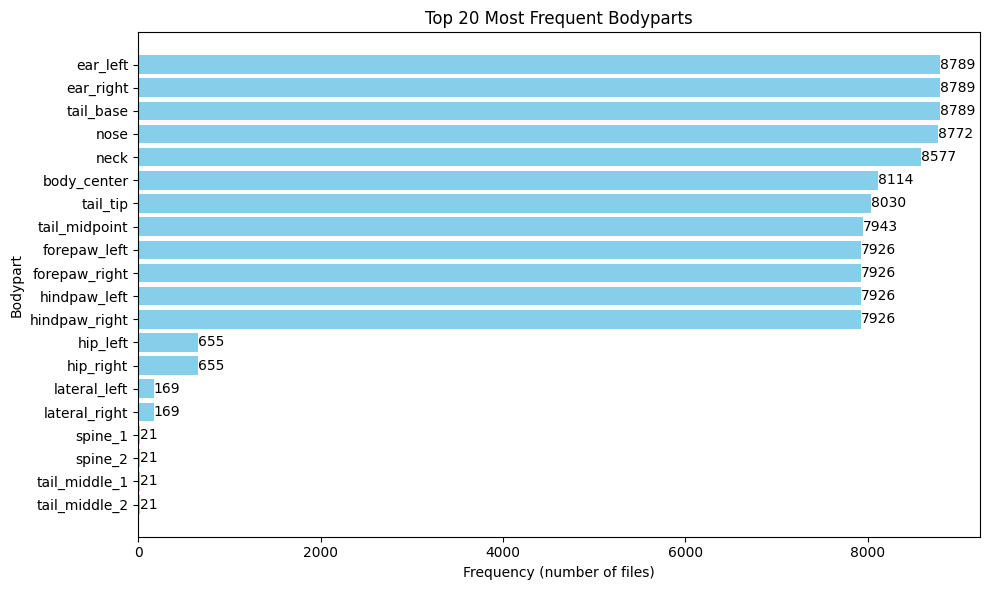

In [5]:
import matplotlib.pyplot as plt

# Prepare data
top_n = 20
bodyparts = list(bodypart_counts_sorted.keys())[:top_n][::-1]
counts = list(bodypart_counts_sorted.values())[:top_n][::-1]

plt.figure(figsize=(10, 6))
bars = plt.barh(bodyparts, counts, color='skyblue')

# Add labels outside the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             str(count), va='center', ha='left', fontsize=10, color='black')

plt.xlabel("Frequency (number of files)")
plt.ylabel("Bodypart")
plt.title(f"Top {top_n} Most Frequent Bodyparts")
plt.tight_layout()
plt.show()


In [6]:
root_dir = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation/AdaptableSnail/1212811043.parquet")
df = pd.read_parquet(root_dir)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   agent_id     370 non-null    int8  
 1   target_id    370 non-null    int8  
 2   action       370 non-null    object
 3   start_frame  370 non-null    int32 
 4   stop_frame   370 non-null    int32 
dtypes: int32(2), int8(2), object(1)
memory usage: 6.6+ KB
None
   agent_id  target_id action  start_frame  stop_frame
0         1          3  chase            2          54
1         1          3  chase          128         234
2         3          2  avoid          324         342
3         3          1  avoid          324         342
4         1          2  chase          942        1052


In [7]:
import pandas as pd
from pathlib import Path
from collections import defaultdict
import math

# -----------------------------
# CONFIG: path to annotation directory
# -----------------------------
root_dir = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation")


# -----------------------------
# FUNCTION: find all parquet files
# -----------------------------
def find_parquet_files(root: Path):
    """Return a list of all parquet files under the root directory."""
    return list(root.rglob("*.parquet"))

# -----------------------------
# FUNCTION: summarize annotations
# -----------------------------
def summarize_annotations(parquet_files):
    """
    For a list of parquet files, calculate:
    - Count of each action
    - Durations (stop_frame - start_frame + 1)
    Missing durations are recorded as NaN.
    
    Returns a pandas DataFrame with one row per action occurrence.
    """
    records = []  # list to store all action occurrences

    for file in parquet_files:
        df = pd.read_parquet(file)

        # Check required columns
        required_cols = ['action', 'start_frame', 'stop_frame']
        for col in required_cols:
            if col not in df.columns:
                # If missing, create column filled with NaN
                df[col] = float('nan')

        # Iterate over each row (action occurrence)
        for _, row in df.iterrows():
            action = row['action']
            start = row['start_frame']
            stop = row['stop_frame']

            # Calculate duration if possible, else NaN
            if pd.notna(start) and pd.notna(stop):
                duration = stop - start + 1
            else:
                duration = float('nan')

            records.append({
                'action': action,
                'start_frame': start,
                'stop_frame': stop,
                'duration': duration
            })

    # Convert to DataFrame
    summary_df = pd.DataFrame(records)

    # Aggregate per action for counts and duration stats
    agg_df = summary_df.groupby('action').agg(
        count=('action', 'count'),
        mean_duration=('duration', 'mean'),
        min_duration=('duration', 'min'),
        max_duration=('duration', 'max')
    ).reset_index()

    # Sort by most frequent actions
    agg_df = agg_df.sort_values('count', ascending=False).reset_index(drop=True)

    return summary_df, agg_df

# -----------------------------
# RUN THE EDA
# -----------------------------
parquet_files = find_parquet_files(root_dir)
print(f"Found {len(parquet_files)} parquet files.")

# Get both the raw action-level DataFrame and the aggregated summary
raw_df, summary_df = summarize_annotations(parquet_files)

# -----------------------------
# VIEW RESULTS
# -----------------------------
print("Aggregated action summary:")
print(summary_df)

print("\nRaw action occurrences (first 5 rows):")
print(raw_df.head())


Found 847 parquet files.
Aggregated action summary:
             action  count  mean_duration  min_duration  max_duration
0             sniff  37837      57.838280             1          6114
1      sniffgenital   7862      90.535869             3         13907
2            attack   7462      70.534977             1          3870
3              rear   4408      53.379537             3          2480
4         sniffbody   3518      30.355884             1           648
5          approach   3270      27.289908             1           685
6         sniffface   2811      26.445393             3           709
7             mount   2747     104.724427             1          3674
8            escape   2071      44.604056             3          1116
9   reciprocalsniff   1492      28.266756             3           433
10           defend   1409      64.862314             2          3161
11        selfgroom   1356      61.295723             4           838
12              dig   1127      70.893

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# FUNCTION: horizontal bar plot of action counts with labels
# -----------------------------
def plot_action_counts(summary_df):
    """
    Create a horizontal bar plot showing the frequency of each action.
    Features:
        - Bars sorted ascending so largest counts appear at the top
        - Numerical count label at end of each bar
        - Clear axis labels and title
    """
    
    # Sort the DataFrame by 'count' in ascending order for horizontal plotting
    # This ensures the most frequent actions are at the top of the plot
    summary_df_sorted = summary_df.sort_values('count', ascending=False)
    
    # Set up the figure size for readability
    plt.figure(figsize=(10, 12))
    
    # Create horizontal bar plot
    ax = sns.barplot(
        data=summary_df_sorted,
        y='action',   # Action labels on Y-axis
        x='count',    # Counts on X-axis
        palette="viridis"  # Color palette for bars
    )
    
    # Add numerical count labels at the end of each bar for readability
    for i, row in enumerate(summary_df_sorted.itertuples()):
        ax.text(
            row.count + max(summary_df_sorted['count'])*0.01,  # Small offset from bar end
            i,  # Vertical position (matches the bar)
            f"{row.count:,}",  # Format with commas
            va='center',  # Vertically center the text with the bar
            fontsize=9
        )
    
    # Set X and Y axis labels
    plt.xlabel("Count")
    plt.ylabel("Action")
    
    # Add plot title
    plt.title("Frequency of Each Action")
    
    # Automatically adjust subplot params for better layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()


import matplotlib.ticker as mtick

# -----------------------------
# FUNCTION: horizontal boxplot of action durations with adjusted min/mean/max labels
# -----------------------------
def plot_action_durations(raw_df, summary_df, log_scale=True):
    """
    Horizontal boxplot of action durations with min, mean, and max annotations.
    Label positions are adjusted to avoid overlapping the boxplot whiskers.

    Parameters:
        raw_df: DataFrame with columns ['action', 'duration']
        summary_df: DataFrame with aggregated stats per action ('min_duration', 'mean_duration', 'max_duration')
        log_scale: bool, whether to use log scale on X-axis
    """
    
    # -----------------------------
    # Sort actions by median duration for plotting
    # -----------------------------
    median_durations = raw_df.groupby('action')['duration'].median().sort_values()
    sorted_actions = median_durations.index.tolist()
    
    # -----------------------------
    # Create figure
    # -----------------------------
    plt.figure(figsize=(12, 14))
    
    # -----------------------------
    # Horizontal boxplot
    # -----------------------------
    ax = sns.boxplot(
        data=raw_df,
        y='action',
        x='duration',
        order=sorted_actions,
        palette="magma"
    )
    
    # -----------------------------
    # Apply log scale if needed
    # -----------------------------
    if log_scale:
        plt.xscale('log')
    
    # -----------------------------
    # Axis labels and title
    # -----------------------------
    plt.xlabel("Duration (frames)")
    plt.ylabel("Action")
    plt.title("Duration Distribution per Action with Min/Mean/Max Labels")
    
    # -----------------------------
    # Format X-axis tick labels
    # -----------------------------
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
    
    # -----------------------------
    # Annotate min, mean, max for each action with adjusted positions
    # -----------------------------
    for i, action in enumerate(sorted_actions):
        stats = summary_df[summary_df['action'] == action].iloc[0]
        min_val = stats['min_duration']
        mean_val = stats['mean_duration']
        max_val = stats['max_duration']
        
        # Multiplicative offsets for log-scale-friendly spacing
        offset_min = 0.92   # push min left by ~15%
        offset_mean = 0.85  # move mean slightly left to be fully inside box
        offset_max = 1.05   # push max right by ~5%
        
        # Annotate min (left of whisker)
        ax.text(min_val * offset_min, i, f"Min: {int(min_val)}", va='center', ha='right', fontsize=8, color='blue')
        # Annotate mean (inside the box)
        ax.text(mean_val * offset_mean, i, f"Avg: {int(mean_val)}", va='center', ha='center', fontsize=8, color='green')
        # Annotate max (right of whisker)
        ax.text(max_val * offset_max, i, f"Max: {int(max_val)}", va='center', ha='left', fontsize=8, color='red')
    
    # -----------------------------
    # Adjust layout and show plot
    # -----------------------------
    plt.tight_layout()
    plt.show()


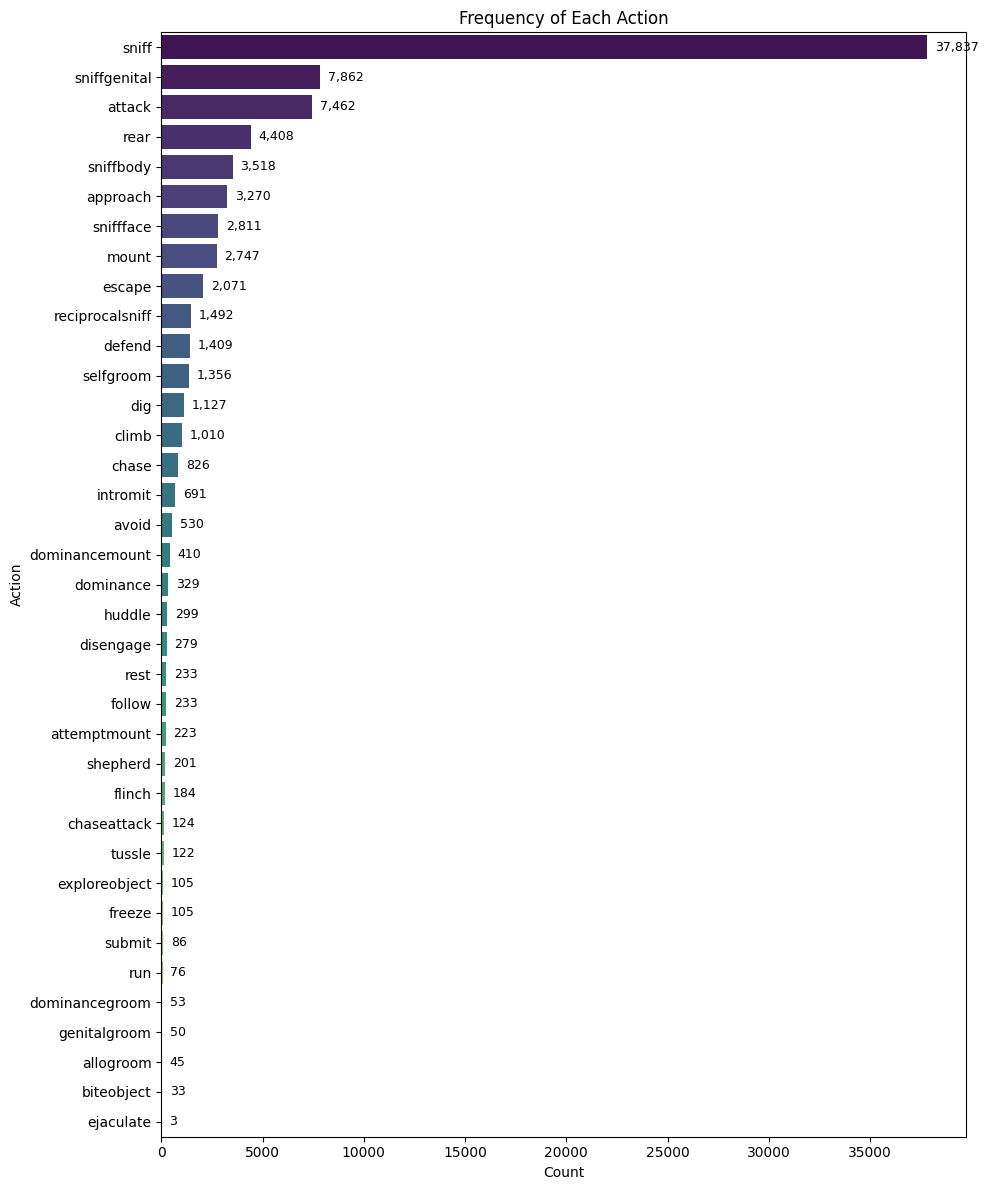

In [9]:
plot_action_counts(summary_df)

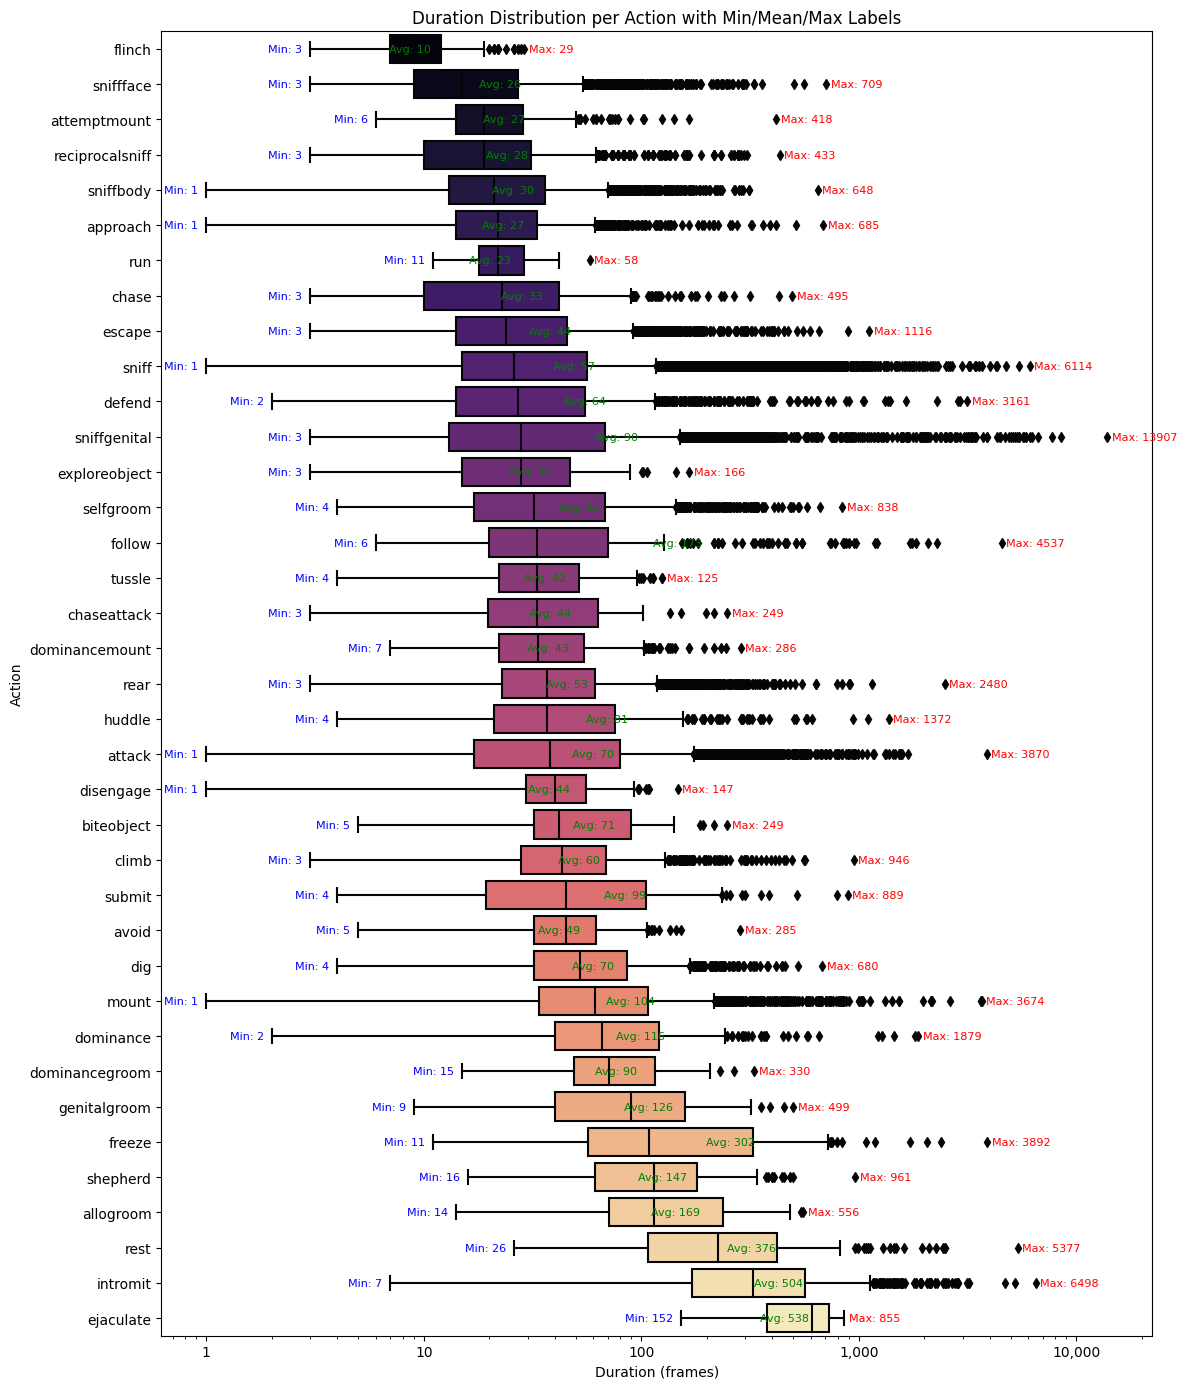

In [10]:
plot_action_durations(raw_df, summary_df)

In [11]:
import pandas as pd
from pathlib import Path

# -----------------------------
# FUNCTION: summarize per-video action statistics
# -----------------------------
def summarize_videos(parquet_dir):
    """
    Reads all annotation parquet files in subdirectories and computes per-video summary statistics.

    Parameters:
        parquet_dir: str or Path, root directory containing subdirectories with parquet files.

    Returns:
        video_summary_df: DataFrame with one row per video, including:
            - video_id: filename without extension
            - total_actions: total number of actions in the video
            - unique_actions: number of different action types
            - mean_duration: mean action duration in frames
            - min_duration: minimum action duration
            - max_duration: maximum action duration
            - action_counts: dictionary of counts per action
    """

    # Ensure Path object for consistent file handling
    root = Path(parquet_dir)
    
    # Find all parquet files recursively
    parquet_files = list(root.rglob("*.parquet"))
    
    # Warn if no files found
    if not parquet_files:
        print("Found 0 parquet files.")
        return pd.DataFrame()  # Return empty DataFrame
    
    # List to store per-video summaries
    summaries = []

    # -----------------------------
    # Iterate over each parquet file (i.e., each video)
    # -----------------------------
    for file_path in parquet_files:
        # Extract video ID from filename (without extension)
        video_id = file_path.stem
        
        # Read parquet file into DataFrame
        try:
            df = pd.read_parquet(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue  # Skip file if reading fails
        
        # Skip if DataFrame is empty
        if df.empty:
            continue
        
        # -----------------------------
        # Compute per-video statistics
        # -----------------------------
        total_actions = len(df)
        unique_actions = df['action'].nunique() if 'action' in df.columns else 0
        
        # Compute durations (stop_frame - start_frame)
        if {'start_frame', 'stop_frame'}.issubset(df.columns):
            df['duration'] = df['stop_frame'] - df['start_frame']
            mean_duration = df['duration'].mean()
            min_duration = df['duration'].min()
            max_duration = df['duration'].max()
        else:
            # Use NaN if frames missing
            mean_duration = min_duration = max_duration = float('nan')
        
        # Count occurrences per action
        if 'action' in df.columns:
            action_counts = df['action'].value_counts().to_dict()
        else:
            action_counts = {}
        
        # Append summary for this video
        summaries.append({
            'video_id': video_id,
            'total_actions': total_actions,
            'unique_actions': unique_actions,
            'mean_duration': mean_duration,
            'min_duration': min_duration,
            'max_duration': max_duration,
            'action_counts': action_counts
        })
    
    # -----------------------------
    # Combine all video summaries into a single DataFrame
    # -----------------------------
    video_summary_df = pd.DataFrame(summaries)
    
    # Sort by total actions descending for convenience
    video_summary_df.sort_values('total_actions', ascending=False, inplace=True)
    
    # Reset index
    video_summary_df.reset_index(drop=True, inplace=True)
    
    return video_summary_df

In [12]:
# -----------------------------
# FUNCTION: histogram of total actions per video with value labels
# -----------------------------
def plot_total_actions_per_video(video_summary_df):
    """
    Histogram showing distribution of total actions per video.
    Features:
        - Dynamic bin sizing using Freedman–Diaconis rule
        - Annotated mean and median lines
        - Count values displayed above each bar (excluding zero-count bars)
        - Cleanly formatted tick labels
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.ticker as mtick

    plt.figure(figsize=(10, 6))

    # -----------------------------
    # Determine dynamic bins
    # -----------------------------
    data = video_summary_df['total_actions']
    q25, q75 = np.percentile(data, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data) ** (-1 / 3)
    bins = int((data.max() - data.min()) / bin_width)
    bins = max(bins, 10)  # ensure at least 10 bins

    # Compute histogram manually to get counts for annotation
    counts, bin_edges = np.histogram(data, bins=bins)

    # Plot histogram as bar chart
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.bar(bin_centers, counts, width=(bin_edges[1]-bin_edges[0]), color='steelblue', edgecolor='white', alpha=0.8)

    # -----------------------------
    # Annotate each bar with its count (skip zero-count bars)
    # -----------------------------
    for x, y in zip(bin_centers, counts):
        if y > 0:
            plt.text(x, y + max(counts)*0.01, f"{y}", ha='center', va='bottom', fontsize=8)

    # -----------------------------
    # Annotate mean & median
    # -----------------------------
    mean_val = data.mean()
    median_val = data.median()
    plt.axvline(mean_val, color='red', linestyle='--', lw=1, label=f"Mean: {mean_val:.1f}")
    plt.axvline(median_val, color='green', linestyle=':', lw=1, label=f"Median: {median_val:.1f}")
    plt.legend()

    # -----------------------------
    # Axis formatting
    # -----------------------------
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
    plt.xlabel("Total Actions per Video")
    plt.ylabel("Number of Videos")
    plt.title("Distribution of Total Actions Across Videos")
    plt.tight_layout()
    plt.show()


In [13]:
# -----------------------------
# FUNCTION: horizontal barplot of mean action durations per video
# -----------------------------
def plot_mean_durations_per_video(video_summary_df, top_n=40):
    """
    Horizontal barplot of mean action durations per video.
    Sorts by mean duration, limits to top-N for clarity, and places numeric labels above bars.

    Parameters:
        video_summary_df : pd.DataFrame
            Must contain columns ['video_id', 'mean_duration']
        top_n : int, optional
            Number of top videos (by mean duration) to display for clarity
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.ticker as mtick

    # -----------------------------
    # Sort videos by mean duration and select top-N
    # -----------------------------
    sorted_videos = video_summary_df.sort_values('mean_duration', ascending=False).head(top_n)

    # Dynamically adjust plot height based on number of videos
    plt.figure(figsize=(10, max(6, top_n * 0.25)))

    # -----------------------------
    # Create horizontal barplot
    # -----------------------------
    ax = sns.barplot(
        data=sorted_videos,
        y='video_id',          # Each bar = one video
        x='mean_duration',     # Bar length = mean duration
        palette='coolwarm'     # Color scheme for visual clarity
    )

    # -----------------------------
    # Add numeric labels ABOVE the bar
    # -----------------------------
    for i, row in enumerate(sorted_videos.itertuples()):
        ax.text(
            row.mean_duration*1.023,        # X position (end of bar)
            i,                  # Y position slightly above the bar
            f"{row.mean_duration:,.1f}",  # Formatted label text
            ha='left',              # Center align horizontally
            va='center',              # Anchor text from the bottom
            fontsize=8,
            color='black'
        )

    # -----------------------------
    # Format axes and title
    # -----------------------------
    plt.xlabel("Mean Action Duration (frames)")
    plt.ylabel("Video ID")
    plt.title(f"Mean Action Duration per Video (Top {top_n})")

    # Add commas to X-axis tick labels for readability
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Tight layout ensures labels and titles fit within the figure
    plt.tight_layout()
    plt.show()


In [14]:
# -----------------------------
# FUNCTION: per-video EDA dashboard
# -----------------------------
def per_video_eda_dashboard(video_summary_df, show_hist=True, show_heatmap=True, show_mean_duration=True):
    """
    Generates a per-video exploratory data analysis dashboard.
    
    Parameters:
        video_summary_df: DataFrame returned from summarize_videos()
        show_hist: bool, whether to show histogram of total actions per video
        show_heatmap: bool, whether to show heatmap of action counts per video
        show_mean_duration: bool, whether to show horizontal barplot of mean durations per video
    """
    
    # -----------------------------
    # Histogram of total actions per video
    # -----------------------------
    if show_hist:
        plot_total_actions_per_video(video_summary_df)
   
    # -----------------------------
    # Horizontal barplot of mean action durations per video
    # -----------------------------
    if show_mean_duration:
        plot_mean_durations_per_video(video_summary_df)


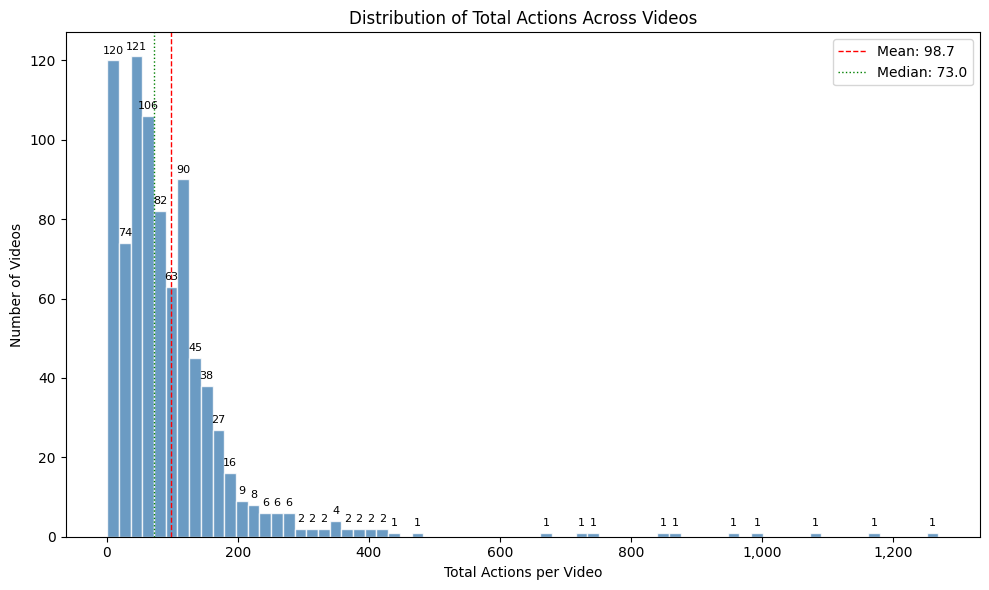

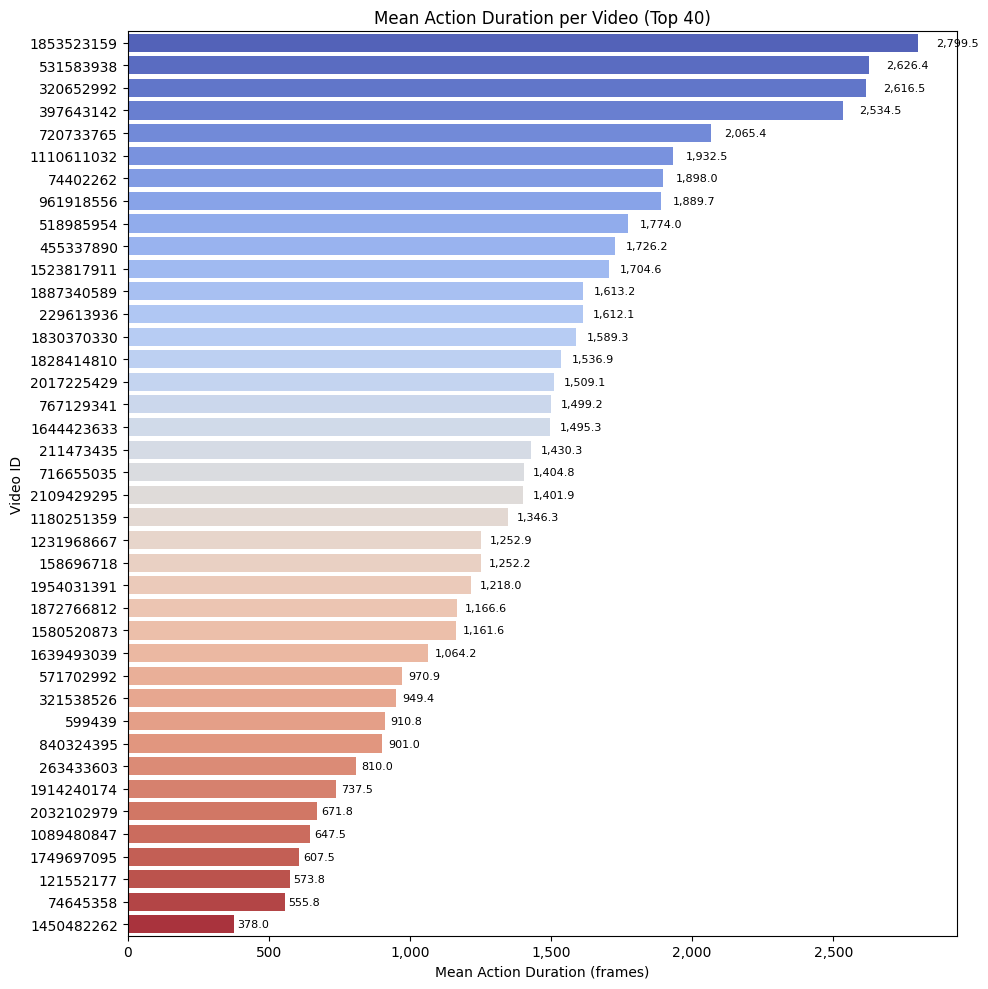

In [15]:
# First, generate per-video summary
video_summary = summarize_videos(comp_annotations)

# Then generate the full dashboard
per_video_eda_dashboard(video_summary)

In [16]:
keypoints = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking/MABe22_keypoints")
tracking_files = list(keypoints.rglob("*.parquet"))
unique_columns = set()
bodypart_counts = Counter()  # to count how many files each bodypart appears in
N = 20  # adjust as needed

# Loop through a subset (or all) of the files
for f in tqdm(tracking_files[::], desc="Analyzing files"):  # can limit to first N for testing
    try:
        df = pd.read_parquet(f)
        unique_columns.update(df.columns)
        
        # Only collect unique entries from 'bodypart' if that column exists
        if 'video_frame' in df.columns:
            bodyparts_in_file = df['video_frame'].dropna().unique()
            bodypart_counts.update(bodyparts_in_file)
            
    except Exception as e:
        print(f"Error reading {f.name}: {e}")

# Sort by most frequent bodyparts
bodypart_counts_sorted = dict(sorted(bodypart_counts.items(), key=lambda x: x[1], reverse=True))
frames_df = pd.DataFrame(list(bodypart_counts_sorted.items()), columns=["frames", "count"])
# Print column names
print(f"Found {len(unique_columns)} unique column names:")
for col in sorted(unique_columns):
    print(f"- {col}")
'''
# Print bodyparts and frequencies
print(f"\nFound {len(bodypart_counts_sorted)} unique frames:")
for bp, count in bodypart_counts_sorted.items():
    print(f"{bp}: {count}")
'''
print(frames_df.info())
    

Analyzing files:   0%|          | 0/5320 [00:00<?, ?it/s]

Found 5 unique column names:
- bodypart
- mouse_id
- video_frame
- x
- y
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   frames  1800 non-null   int16
 1   count   1800 non-null   int64
dtypes: int16(1), int64(1)
memory usage: 17.7 KB
None


In [17]:
path = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking/MABe22_keypoints/1000217804.parquet")
df = pd.read_parquet(path)
print(df.head())
print(df.info())

   video_frame  mouse_id       bodypart      x      y
0            0         1    body_center  380.0  138.0
1            0         1       ear_left  352.0  160.0
2            0         1      ear_right  334.0  141.0
3            0         1   forepaw_left  356.0  157.0
4            0         1  forepaw_right  346.0  143.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64800 entries, 0 to 64799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   video_frame  64800 non-null  int16  
 1   mouse_id     64800 non-null  int8   
 2   bodypart     64800 non-null  object 
 3   x            64800 non-null  float32
 4   y            64800 non-null  float32
dtypes: float32(2), int16(1), int8(1), object(1)
memory usage: 1.2+ MB
None


In [18]:
# -----------------------------
# FUNCTION: summarize columns across all parquet files with progress bar
# -----------------------------
def summarize_parquet_columns(parquet_dir):
    """
    Summarize column structure across all parquet files in a directory, with a progress bar.
    
    Parameters:
        parquet_dir: str or Path - directory containing parquet files
    
    Returns:
        column_summary_df: DataFrame with columns:
            - column_name: column name found in parquet files
            - file_count: number of files containing this column
    """
    parquet_dir = Path(parquet_dir)
    
    # List all parquet files
    file_list = list(parquet_dir.glob("*.parquet"))
    print(f"Found {len(file_list)} parquet files in {parquet_dir}")
    
    all_columns = []

    # -----------------------------
    # Iterate over files with progress bar
    # -----------------------------
    for file_path in tqdm(file_list, desc="Processing parquet files"):
        try:
            df = pd.read_parquet(file_path)
            all_columns.extend(df.columns.tolist())
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    # Count how many files contain each column
    column_counts = Counter(all_columns)
    
    # Convert to DataFrame for easy viewing
    column_summary_df = pd.DataFrame.from_dict(
        column_counts, orient='index', columns=['file_count']
    ).reset_index().rename(columns={'index': 'column_name'})
    
    # Sort by frequency descending
    column_summary_df = column_summary_df.sort_values('file_count', ascending=False).reset_index(drop=True)
    
    return column_summary_df

# -----------------------------
# Example usage
# -----------------------------
annotated_merged_path = Path("/kaggle/input/fixed-merged-files/annotated_fixed")
column_summary = summarize_parquet_columns(annotated_merged_path)



Found 847 parquet files in /kaggle/input/fixed-merged-files/annotated_fixed


Processing parquet files:   0%|          | 0/847 [00:00<?, ?it/s]

In [19]:
print(column_summary.info())
print(column_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   column_name  63 non-null     object
 1   file_count   63 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
                  column_name  file_count
0              lateral_left_y         847
1     headpiece_topbackleft_x         847
2             tail_middle_1_x         847
3                  ear_left_y         847
4              forepaw_left_y         847
..                        ...         ...
58             forepaw_left_x         847
59  headpiece_topfrontright_y         847
60             hindpaw_left_y         847
61            tail_middle_2_y         847
62                     action         847

[63 rows x 2 columns]


In [20]:

# -----------------------------
# FUNCTION: combine X/Y coordinate columns into single (x, y) tuple columns with NaN handling
# -----------------------------
def combine_xy_columns_with_nan(df):
    """
    Combine '_x' and '_y' columns for each body part into a single column
    containing a tuple (x, y), preserving NaN values.
    
    If either X or Y is NaN in a row, the combined value will be NaN.

    Parameters:
        df: pd.DataFrame - dataframe with columns like 'forepaw_left_x', 'forepaw_left_y'

    Returns:
        combined_df: pd.DataFrame - dataframe with combined coordinate columns
    """
    combined_df = df.copy()
    
    # Find all column names ending with '_x'
    x_cols = [col for col in combined_df.columns if col.endswith('_x')]
    
    for x_col in x_cols:
        y_col = x_col[:-2] + '_y'  # corresponding y column
        if y_col in combined_df.columns:
            combined_col_name = x_col[:-2]  # e.g., 'forepaw_left'
            
            # Combine X and Y, set NaN if either is NaN
            combined_df[combined_col_name] = combined_df.apply(
                lambda row: (row[x_col], row[y_col]) 
                if pd.notna(row[x_col]) and pd.notna(row[y_col]) else np.nan,
                axis=1
            )
            
            # Drop the original X and Y columns
            combined_df.drop([x_col, y_col], axis=1, inplace=True)
    
    return combined_df

# -----------------------------
# Example usage
# -----------------------------
# Assuming `df` is one of your loaded parquet files
load_parquet = Path("/kaggle/input/fixed-merged-files/annotated_fixed/1006083669_fixed.parquet")
df=pd.read_parquet(load_parquet)

combined_df = combine_xy_columns_with_nan(df)



In [21]:
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36782 entries, 0 to 36781
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   video_frame                 36782 non-null  int16  
 1   mouse_id                    36782 non-null  int8   
 2   agent_id                    7748 non-null   float64
 3   target_id                   7748 non-null   float64
 4   action                      7748 non-null   object 
 5   hindpaw_right               0 non-null      float64
 6   lateral_left                0 non-null      float64
 7   body_center                 0 non-null      float64
 8   headpiece_bottombackleft    0 non-null      float64
 9   spine_1                     0 non-null      float64
 10  tail_middle_2               0 non-null      float64
 11  ear_left                    36782 non-null  object 
 12  headpiece_topbackright      0 non-null      float64
 13  neck                        367

In [22]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

# -----------------------------
# FUNCTION: combine X/Y columns into single (x, y) tuples with NaN handling
# -----------------------------
def combine_xy_columns_with_nan(df):
    """
    Combine '_x' and '_y' columns into a single (x, y) tuple column.
    If either value is NaN, the cell is set to NaN.
    Non-coordinate columns are preserved.
    """
    combined_df = df.copy()
    
    x_cols = [col for col in combined_df.columns if col.endswith('_x')]
    
    for x_col in x_cols:
        y_col = x_col[:-2] + '_y'
        if y_col in combined_df.columns:
            combined_col_name = x_col[:-2]
            
            # Combine x and y, set NaN if either is NaN
            combined_df[combined_col_name] = combined_df.apply(
                lambda row: (row[x_col], row[y_col])
                if pd.notna(row[x_col]) and pd.notna(row[y_col]) else np.nan,
                axis=1
            )
            
            # Drop original x and y columns
            combined_df.drop([x_col, y_col], axis=1, inplace=True)
    
    return combined_df

# -----------------------------
# FUNCTION: process all parquet files in a directory
# -----------------------------
def process_parquet_folder(input_path, output_path):
    """
    Process all parquet files in a folder: combine coordinates and save cleaned files.
    
    Parameters:
        input_path: Path to input folder containing parquet files
        output_path: Path to save cleaned parquet files
    """
    input_path = Path(input_path)
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)  # Create folder if it doesn't exist
    
    # Find all parquet files
    parquet_files = list(input_path.glob("*.parquet"))
    print(f"Found {len(parquet_files)} parquet files to process.")
    
    # Iterate with progress bar
    for file_path in tqdm(parquet_files, desc="Processing parquet files"):
        try:
            df = pd.read_parquet(file_path)
            cleaned_df = combine_xy_columns_with_nan(df)
            cleaned_df.to_parquet(output_path / file_path.name, index=False)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# -----------------------------
# Example usage
# -----------------------------
input_dir = "/kaggle/input/fixed-merged-files/annotated_fixed"
output_dir = "/kaggle/working/feature-extraction"

process_parquet_folder(input_dir, output_dir)


Found 847 parquet files to process.


Processing parquet files: 100%|██████████| 847/847 [3:36:56<00:00, 15.37s/it]


In [23]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Directories
# -----------------------------
input_dir = Path("/kaggle/working/feature-extraction")
output_dir = Path("/kaggle/working/core-feature-extraction")
output_dir.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Crucial features for ML modeling
# -----------------------------
important_features = [
    "ear_left", "ear_right", "tail_base", "nose"
]

# Always-keep columns (metadata + labels)
meta_columns = ["video_frame", "mouse_id", "agent_id", "target_id", "action"]

# Combine all required columns
required_columns = important_features + meta_columns

# -----------------------------
# Process parquet files
# -----------------------------
parquet_files = list(input_dir.glob("*.parquet"))
print(f"Checking {len(parquet_files)} parquet files for required core features...")

summary_records = []

for file_path in tqdm(parquet_files, desc="Filtering parquet files"):
    try:
        df = pd.read_parquet(file_path)
        record = {"filename": file_path.name}

        # Track missing or all-null features
        missing_columns = [col for col in required_columns if col not in df.columns]
        null_columns = [col for col in important_features if col in df.columns and not df[col].notna().any()]

        # Store counts of non-null entries for each important feature
        for feat in important_features:
            if feat in df.columns:
                record[f"{feat}_non_null"] = df[feat].notna().sum()
            else:
                record[f"{feat}_non_null"] = 0

        # Decide whether to keep or drop file
        if missing_columns or null_columns:
            record["status"] = "dropped"
            record["reason"] = f"Missing: {missing_columns}, Empty: {null_columns}"
        else:
            record["status"] = "kept"
            record["reason"] = ""
            df_filtered = df[required_columns]
            df_filtered.to_parquet(output_dir / file_path.name, index=False)

        summary_records.append(record)

    except Exception as e:
        summary_records.append({
            "filename": file_path.name,
            "status": "error",
            "reason": str(e)
        })

# -----------------------------
# Save summary report
# -----------------------------
summary_df = pd.DataFrame(summary_records)
summary_csv_path = output_dir / "core_feature_selection_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)

# -----------------------------
# Summary printout
# -----------------------------
kept_count = (summary_df["status"] == "kept").sum()
dropped_count = (summary_df["status"] == "dropped").sum()
error_count = (summary_df["status"] == "error").sum()

print(f"\n✅ Core feature filtering complete!")
print(f"Kept {kept_count} files, dropped {dropped_count}, errors {error_count}.")
print(f"Summary CSV saved to: {summary_csv_path}")


Checking 847 parquet files for required core features...


Filtering parquet files: 100%|██████████| 847/847 [04:52<00:00,  2.89it/s]


✅ Core feature filtering complete!
Kept 830 files, dropped 17, errors 0.
Summary CSV saved to: /kaggle/working/core-feature-extraction/core_feature_selection_summary.csv


In [24]:
df=pd.read_csv("/kaggle/working/core-feature-extraction/core_feature_selection_summary.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   filename            847 non-null    object
 1   ear_left_non_null   847 non-null    int64 
 2   ear_right_non_null  847 non-null    int64 
 3   tail_base_non_null  847 non-null    int64 
 4   nose_non_null       847 non-null    int64 
 5   status              847 non-null    object
 6   reason              17 non-null     object
dtypes: int64(4), object(3)
memory usage: 46.4+ KB
None


In [25]:
unique_reasons = df["reason"].unique()
print(f"Found {len(unique_reasons)} unique drop reasons:\n")
for r in unique_reasons:
    print("-", r)

Found 2 unique drop reasons:

- nan
- Missing: [], Empty: ['nose']


In [26]:
# Count frequencies for each reason
reason_counts = df["reason"].value_counts()
print(reason_counts)

reason
Missing: [], Empty: ['nose']    17
Name: count, dtype: int64
